# Introduction

The aim of the challenge is to implement and achieve automatic portrait segmentation. Automatically identifying portraits has many applications such as image stylization, where background can be replaced to stylize the image. We use the given dataset with assuming that the portrait images generally are restricted to person's faces and so the faces in the images, indicated by the bounding box data, are the foreground and rest of the image is the background. Since this task is similar to semantic segmentation we use a pretrained segmentation model trained on augmented PASCAL VOC dataset which has a person class and finetune the model using our dataset.

In [19]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import time
from scipy import misc
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from model import *   # This has the model(neural network) we will be using for this problem
import pandas as pd

In [2]:
def neural_net_image_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        return tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")
def neural_net_label_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        return tf.placeholder(tf.uint8,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="y")

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32,name="keep_prob")

In [3]:
# We are using a model trained on pascal voc dataset, which has the following categories defined and finetuning the model for our purposes
label_colours = [(0,0,0)
                # 0=background
                ,(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128)
                # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                ,(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0)
                # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                ,(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128)
                # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                ,(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
                # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    
def decode_labels(mask):
    """Decode batch of segmentation masks.
    
    Args:
      label_batch: result of inference after taking argmax.
    
    Returns:
      An batch of RGB images of the same size
    """
    imgrgb = Image.new('RGB', (len(mask[0]), len(mask)))
    pixels = imgrgb.load()
    for j_, j in enumerate(mask):
        for k_, k in enumerate(j):
            if k < 21:
                pixels[k_,j_] = label_colours[k]
    return np.array(imgrgb)
def encode_labels(label_batch):
        colormap = {(0,0,0):0, (128,0,0):1, (0,128,0):2, (128,128,0):3, (0,0,128):4, (128,0,128):5, (0,128,128):6, (128,128,128):7, (64,0,0):8, (192,0,0):9, (64,128,0):10, (192,128,0):11, (64,0,128):12, (192,0,128):13, 
            (64,128,128):14, (192,128,128):15, (0,64,0):16, (128,64,0):17, (0,192,0):18, (128,192,0):19, (0,64,128):20}                                            
        gndTruth = np.zeros((label_batch.shape[0],label_batch[0].shape[0],label_batch[0].shape[1],1), dtype=np.int)
        for i in range(gndTruth.shape[0]):
            for j in range(gndTruth.shape[1]):
                for k in range(gndTruth.shape[2]):   
                    if(colormap.get(tuple(label_batch[i][j,k]))):
                        gndTruth[i,j,k]=colormap.get(tuple(label_batch[i][j,k]))
                    else:
                        gndTruth[i,j,k] = 0
        return gndTruth
def load_preprocess_val_batch(batch_id):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    with tf.name_scope("create_inputs"):
        filename = 'preprocessed_data/val_data/pre_processed_batch_' + str(batch_id) + '.p'
        loaded_features, loaded_labels = cPickle.load(open(filename, mode='rb'))
        return loaded_features.astype(np.int64), loaded_labels.astype(np.int64)
    


In [4]:
#CELEBA dataset has this file , which should be used to divide the dataset into 
#training - 0, 
#validation -1 
#testing - 2 

evalData = pd.read_csv('evalpartition.txt',sep=" ",header=None,skipinitialspace=True,names=['image_name','dataset_type'])
evalData.set_index('dataset_type',inplace=True)
valData = evalData.loc[1].reset_index()['image_name']


In [37]:
im_sz = 500    # height and width to which all images will be resized to
batch_size=16  # dataset will be divided into batches of this size
num_val_batches = int(len(valData)/batch_size)

In [49]:
tf.reset_default_graph()

# for validation only CPU can be used
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

net = SegmentationModel(None)

imgold = neural_net_image_input((im_sz, im_sz, 3))
x = neural_net_image_input((im_sz, im_sz, 3))
y = neural_net_label_input((im_sz, im_sz, 1))
keep_prob = neural_net_keep_prob_input()

pred = net.preds(x)
predconv = tf.to_int32(pred, name='ToInt32')
yconv = tf.to_int32(y, name='ToInt32') 

#mean IOU (Intersection over union) is a metric used for the task of semantic segmentation (here portrait segmentation)
mIoU, update_op = tf.contrib.metrics.streaming_mean_iou(predconv,yconv, num_classes=21)

sess = tf.Session(config=config)
init = tf.initialize_all_variables()    
sess.run(init)
sess.run(tf.initialize_local_variables())

saver = tf.train.Saver()
saver.restore(sess, "model/model.ckpt")
test_input=np.zeros([1,im_sz,im_sz,3],dtype=np.int)
lbl_img = np.zeros([1,im_sz,im_sz,1],dtype=np.int)

predimages = np.zeros([batch_size,im_sz,im_sz,1],dtype=int)
num_val_batches=1 # printing data for one batch ( for example)
for batch_i in range(num_val_batches):
    batch_i=5   # printing data for one batch ( for example)
    batch_features, batch_labels = load_preprocess_val_batch(batch_i)
    for img_i in range(batch_size):
        test_input[0,:,:,:] = batch_features[img_i,:,:,:]
        lbl_img[0,:,:,0] = batch_labels[img_i,:,:,0]
        pred_value,up = sess.run([pred,update_op],feed_dict={x:test_input,y:lbl_img})
        predimages[img_i,:,:,:] = pred_value[0,:,:,:]
        print('miou: '+ str(mIoU.eval(session=sess)))
print('batch: '+ str(batch_i))


INFO:tensorflow:Restoring parameters from model/model.ckpt
miou: 0.97597533
miou: 0.94823194
miou: 0.93308693
miou: 0.9395124
miou: 0.9343871
miou: 0.9299934
miou: 0.6536574
miou: 0.6759488
miou: 0.7151912
miou: 0.72467136
miou: 0.73428655
miou: 0.75641644
miou: 0.7659766
miou: 0.775983
miou: 0.7815697
miou: 0.74854285
batch: 5


# Results

In [44]:
def getLabelImage(input_img, boundbox):
    b=np.zeros([input_img.shape[0],input_img.shape[1],3],dtype=int)
    for i in range(0,input_img.shape[0]):
        for j in range(0,input_img.shape[1]):
            if((j>boundbox.x_1) and (j<(boundbox.x_1+boundbox.width)) and (i>boundbox.y_1) and (i<(boundbox.y_1+boundbox.height))):
                b[i,j,:] = input_img[i,j,:] 
    return b

In [45]:
def getResizedImages(input_img,b,im_sz):
    sess = tf.Session()
    img_tensor = tf.image.resize_image_with_crop_or_pad(input_img, im_sz, im_sz)
    labels_tensor = tf.image.resize_image_with_crop_or_pad(b, im_sz, im_sz)

    img, lblimg = sess.run([img_tensor,labels_tensor])
    return img,lblimg

In [65]:
def getOutput(input_img_resized, pred_value, im_sz):
    p = np.zeros([im_sz,im_sz,3],dtype=int)
    for i in range(0,input_img_resized.shape[0]):
        for j in range(0,input_img_resized.shape[1]):
            if(pred_value[i,j,0]>0):
                p[i,j,:] = input_img_resized[i,j,:] 
    return p

In [66]:
#Lets look at the segmented image by taking two sample images

#input images from 5th batch

bbdata = pd.read_csv('list_bbox_celeba.txt',sep=" ",header=0,skiprows=1,skipinitialspace=True)
bbdata.set_index('image_id',inplace=True)

input_img_name_1 = valData[int(5*16)+1]   #because valdata was divided into batches of 16
input_img_name_2 = valData[int(5*16)+10]  

# read input images
input_img_1 = misc.imread("data/"+input_img_name_1)
input_img_2 = misc.imread("data/"+input_img_name_2)

# get the bounding box pixels
boundbox_1 = bbdata.loc[input_img_name_1]   
boundbox_2 = bbdata.loc[input_img_name_2]

#get corresponding groundtruth images
lblimg_1 = getLabelImage(input_img_1,boundbox_1)
lblimg_2 = getLabelImage(input_img_2,boundbox_2)

#get resized input and groundtruths
input_img_resized_1, lbl_img_resized_1 = getResizedImages(input_img_1,lblimg_1,im_sz)
input_img_resized_2, lbl_img_resized_2 = getResizedImages(input_img_2,lblimg_2,im_sz)


#get output
output_1 = getOutput(input_img_resized_1,predimages[1],im_sz)
output_2 = getOutput(input_img_resized_2,predimages[10],im_sz)

Plotting resized input images 

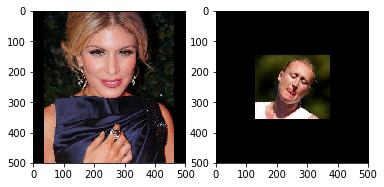

In [54]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(input_img_resized_1)
axarr[1].imshow(input_img_resized_2)


Plot corresponding groundtruths

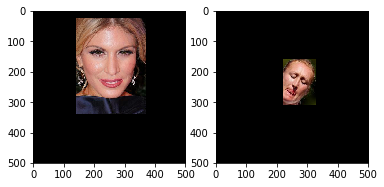

In [59]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(lbl_img_resized_1)
axarr[1].imshow(lbl_img_resized_2)

Plotting corresponding outputs

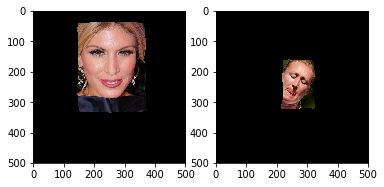

In [67]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(output_1)
axarr[1].imshow(output_2)


# Conclusion

The aim of the challenge was to implement and achieve portrait segmentation, which is the task of identifying portrait(foreground) in the image and separating it from the background. But we saw that CELEBA dataset does not have the labelled output data discriminating foreground from the background. After exploring the dataset further we found that the dataset has information on the bounding boxes of faces for all the images. Generally portrait images are more focussed towards the face of the person with some extending till the shoulders, so we put the data available for our use. We generate output data by labelling all the region inside the bounding box as foreground and rest as background.
We started with the idea that portrait segmentation and semantic segmentation are similar tasks, so we used a segmentation model trained on augmented PASCAL VOC dataset, finetuned the model and successfully achieved a mean IOU score of 0.75 on the validation dataset.